


Training Model 1
Epoch 1/75


62/62 [==============================] - 1381s 14s/step - loss: 0.5488 - accuracy: 0.7631
Epoch 2/75
62/62 [==============================] - 812s 13s/step - loss: 0.3229 - accuracy: 0.8725
Epoch 3/75
62/62 [==============================] - 765s 12s/step - loss: 0.3009 - accuracy: 0.8780
Epoch 4/75
62/62 [==============================] - 738s 12s/step - loss: 0.2415 - accuracy: 0.8962
Epoch 5/75
62/62 [==============================] - 762s 12s/step - loss: 0.2153 - accuracy: 0.9123
Epoch 6/75
62/62 [==============================] - 696s 11s/step - loss: 0.2069 - accuracy: 0.9123
Epoch 7/75
62/62 [==============================] - 685s 11s/step - loss: 0.1476 - accuracy: 0.9395
Epoch 8/75
62/62 [==============================] - 683s 11s/step - loss: 0.1482 - accuracy: 0.9415
Epoch 9/75
62/62 [==============================] - 690s 11s/step - loss: 0.1338 - accuracy: 0.9471
Epoch 10/75
62/62 [==============================] - 614s 10s/step - loss: 0.

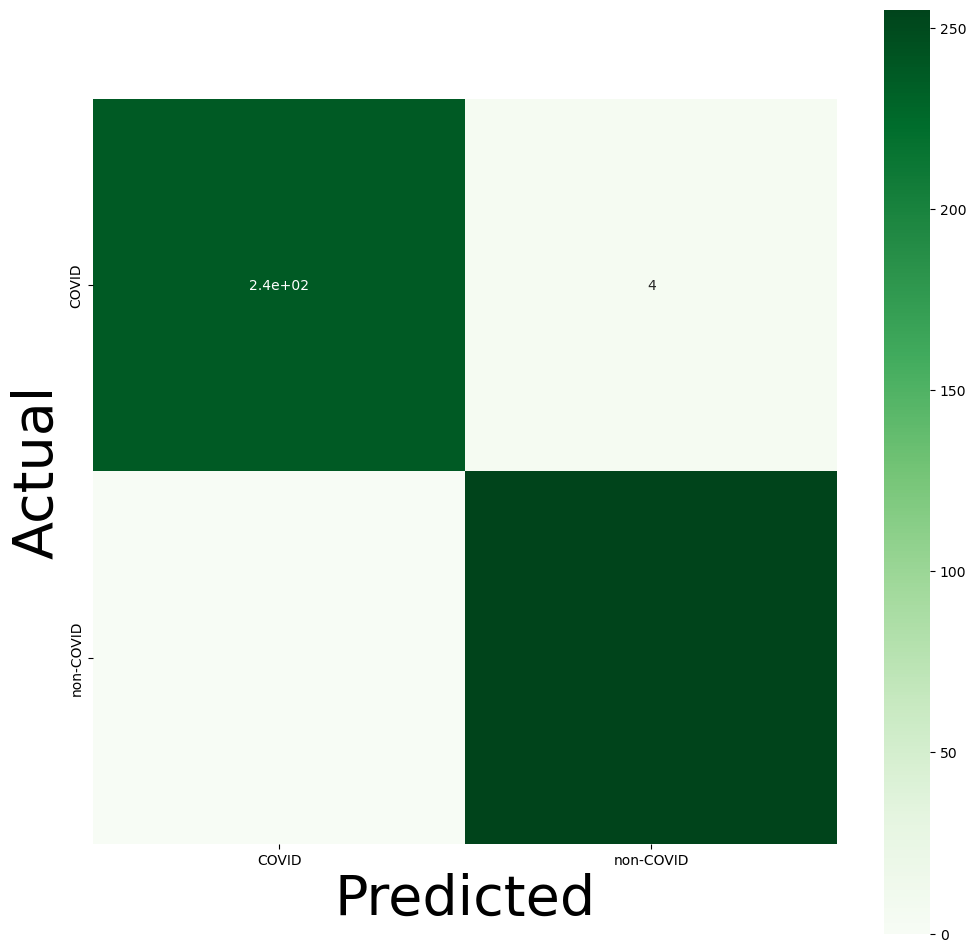

In [2]:
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.layers import Dense, Conv2D, BatchNormalization, GlobalAveragePooling2D, Input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

# Set seed for reproducibility
Seed = 40
np.random.seed(Seed)

data_dir = '../../Data/covid/SARS-CoV-2-CT-Scan'

# Load and preprocess data
disease_types = ['COVID', 'non-COVID']

train_data = []

for index, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(data_dir, sp)):
        train_data.append([sp + "/" + file, index, sp])

train = pd.DataFrame(train_data, columns=['File', 'ID', 'Disease Type'])

# Reset indices (row numbers)
train = train.sample(frac=1, replace=False, random_state=Seed)
train = train.reset_index(drop=True)

# Assuming you have defined IMAGE_SIZE and channels
IMAGE_SIZE = 224
channels = 3

# OpenCV Function to load colored image
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath))

# OpenCV Function to resize an image
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))

for i, file in enumerate(train['File'].values):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))

X_train = X_train / 255.0  # Pixel normalization

Y_train = to_categorical(train['ID'].values, num_classes=2)

# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=Seed)


# Function to build DenseNet169 model
def build_densenet169(IMAGE_SIZE, channels):
    densenet169 = DenseNet169(weights='imagenet', include_top=False)
    input = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, channels))
    x = Conv2D(3, (3, 3), padding='same')(input)
    x = densenet169(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    output = Dense(2, activation='softmax')(x)

    model = Model(input, output)

    initial_learning_rate = 0.003
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=100000,  # Adjust this value as needed
        decay_rate=0.96,
        staircase=True)

    optimizer = Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=0.1)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

# Build three separate DenseNet169 models
model1 = build_densenet169(IMAGE_SIZE, channels)
model2 = build_densenet169(IMAGE_SIZE, channels)
model3 = build_densenet169(IMAGE_SIZE, channels)

# Data augmentation
datagen = ImageDataGenerator(rotation_range=360, width_shift_range=0.2, height_shift_range=0.2,
                             zoom_range=0.2, horizontal_flip=True, vertical_flip=True)
datagen.fit(X_train)

# Train each model separately
models = [model1, model2, model3]
for i, model in enumerate(models):
    print(f"\nTraining Model {i + 1}")
    hist = model.fit(datagen.flow(X_train, Y_train, batch_size=32),
                     steps_per_epoch=X_train.shape[0] // 32,
                     epochs=75,  # Adjust the number of epochs as needed
                     verbose=1)

# Ensemble model by averaging predictions
def ensemble_predict(models, X_val):
    predictions = [model.predict(X_val) for model in models]
    ensemble_pred = np.mean(predictions, axis=0)
    return ensemble_pred

# Evaluate the ensemble model
ensemble_predictions = ensemble_predict(models, X_val)
ensemble_predictions = np.argmax(ensemble_predictions, axis=1)
Y_true = np.argmax(Y_val, axis=1)

ensemble_cm = confusion_matrix(Y_true, ensemble_predictions)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(ensemble_cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

# Calculate and print metrics
ensemble_TP = ensemble_cm[1][1]
ensemble_FN = ensemble_cm[1][0]
ensemble_TN = ensemble_cm[0][0]
ensemble_FP = ensemble_cm[0][1]

print(f"Ensemble True Positive: {ensemble_TP}")
print(f"Ensemble False Negative: {ensemble_FN}")
print(f"Ensemble True Negative: {ensemble_TN}")
print(f"Ensemble False Positive: {ensemble_FP}")
print(f"Ensemble True Positive Rate: {ensemble_TP / (ensemble_TP + ensemble_FN)}")
print(f"Ensemble True Negative Rate: {ensemble_TN / (ensemble_TN + ensemble_FP)}")


In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate and print precision, recall, and F1 score
ensemble_accuracy = accuracy_score(Y_true, ensemble_predictions)
ensemble_precision = precision_score(Y_true, ensemble_predictions)
ensemble_recall = recall_score(Y_true, ensemble_predictions)
ensemble_f1 = f1_score(Y_true, ensemble_predictions)

print(f"Ensemble Accuracy: {ensemble_accuracy}")
print(f"Ensemble Precision: {ensemble_precision}")
print(f"Ensemble Recall: {ensemble_recall}")
print(f"Ensemble F1 Score: {ensemble_f1}")


Ensemble Accuracy: 0.9919517102615694
Ensemble Precision: 0.9845559845559846
Ensemble Recall: 1.0
Ensemble F1 Score: 0.9922178988326849


Ensemble Accuracy: 0.9919517102615694
Ensemble Precision: 0.9845559845559846
Ensemble Recall: 1.0
Ensemble F1 Score: 0.9922178988326849


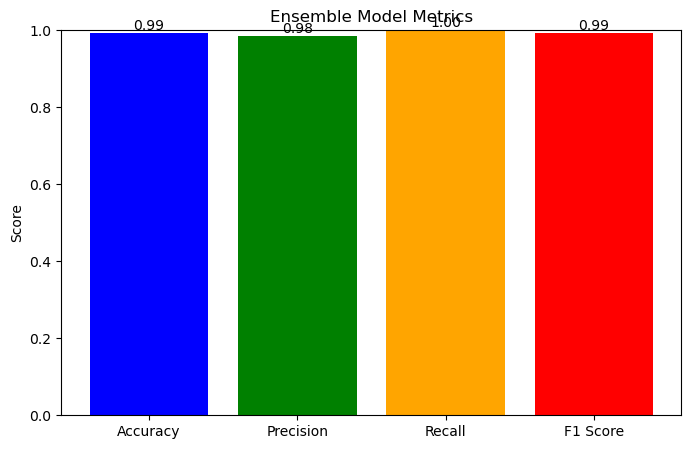

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate and print precision, recall, and F1 score
ensemble_accuracy = accuracy_score(Y_true, ensemble_predictions)
ensemble_precision = precision_score(Y_true, ensemble_predictions)
ensemble_recall = recall_score(Y_true, ensemble_predictions)
ensemble_f1 = f1_score(Y_true, ensemble_predictions)

print(f"Ensemble Accuracy: {ensemble_accuracy}")
print(f"Ensemble Precision: {ensemble_precision}")
print(f"Ensemble Recall: {ensemble_recall}")
print(f"Ensemble F1 Score: {ensemble_f1}")

# Results
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
metrics_values = [ensemble_accuracy, ensemble_precision, ensemble_recall, ensemble_f1]

# Bar plot
plt.figure(figsize=(8, 5))
bars = plt.bar(metrics_names, metrics_values, color=['blue', 'green', 'orange', 'red'])
plt.ylim(0, 1)  # Set the y-axis limit to be between 0 and 1 for better visualization
plt.title('Ensemble Model Metrics')
plt.ylabel('Score')


# Function to add value labels on top of the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., height,
                 f'{height:.2f}', ha='center', va='bottom')

# Call the function to add labels
autolabel(bars)

plt.show()
